# PyLSCI Demo

This notebook demonstrates the usage of the `pylsci` package.

The `pylsci` package expects the raw laser speckle data as 2D or 3D NumPy arrays, 
and it will be assumed that you provide the functionality to convert your laser speckle data to NumPy arrays.

For the demo purposes of this notebook, the `util.py` module was created. 
It contains the functionality to read images to NumPy arrays, as well as showing them using `matplotlib`.
Note that neither the custom `util.py` module nor `matplotlib` is required to use the `pylsci` package, 
and they won't be installed when you install `pylsci`, and it's only dependency is the NumPy package.

With `pylsci`, you can calculate 
- spatial,
- temporal, and
- spatio-temporal

Laser Speckle Contrast Images. 
Those three ways of calculating LSCI Images will be demonstrated in this notebook.

Using `pylsci`, it is recommended to use temporal LSCI whenever possible, 
since the temporal implementation can make use of NumPys numerical advantages for multi-dimensional arrays.
This is not the case for the spatial and spatio-temporal implementation,
where we need a kernel to iterate the image(s), making it computationally expensive.

> I tried to find a Python/NumPy equivalent for the MATLAB `imfilter` function.
> It seems like you can achieve similar using [SciPy](https://mail.python.org/pipermail/scipy-user/2013-May/034559.html),
> but my intention is to avoid using another package dependency, since I prefer lightweight packages.
> If you have any idea to optimize the spatial and spatio-temporal implementation, 
> you can post in this [GitHub Issue](https://github.com/pkeilbach/pylsci/issues/1), 
> or feel free to [contact me](mailto:python@pk17.org)

## 0. Preparations

To successfully execute this notebook, you will need to install `pylsci`, 
as well as `matplotlib` (just to show the images). `pylsci` will also install NumPy.

```python
# to use the pylsci package
pip install pylsci

# and in addition to use this notebook
pip install matplotlib
```

Now, let's start by importing the helper functions from the custom `util.py` module.

> Again, the `util.py` contains custom preprocessing, that is highly dependent on your specific LSCI setup.
> Just make sure that in the end, you have your data available as 2D or 3D NumPy arrays.


In [1]:
from util import show_image, read_image

## 1. Spatial Contrast Calculation

Lets start by loading a raw laser speckle image. This example shows a speckle image of a rat cortex.

> Kudos to Biomedical Scientist Dmity Postnov for providing the raw laser speckle image.

After reading it, we have the raw laser speckle image available as a 2D numpy array of size $1024 \times 1280$ pixels.


<class 'numpy.ndarray'>
image dimensions: (1024, 1280)


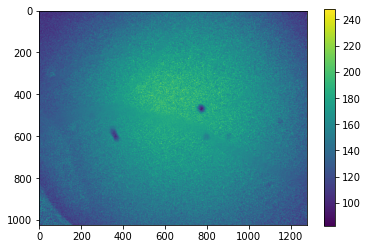

In [2]:
raw_speckle_img = read_image('img/spatial.tif')
print(type(raw_speckle_img))
show_image(raw_speckle_img)

Now, we can calculate a laser speckle contrast image using `pylsci`.

The basic workflow is:

- create an `Lsci` object, and
- execute a contrast function on the loaded speckle image.

The default value for the spatial neighborhood is `nbh_s=3`, and for the temporal neighborhood it is `nbh_t=25`.
If you don't pass anything to the constructor, `pylsci` will use those values for the spatial and temporal neighborhoods.

However, you can pass custom values for `nbh_s` and `nbh_t`

> Note that `nbh_s` is expected to be an odd value, since the kernel should center around a single pixel, 
> e.g. `nbh_s=3` uses a kernel of $3 \times 3$ pixels.

In this example, we will create an object of the `Lsci` class using the default values, 
which will give us a spatial kernel of $3 \times 3 pixels$ 

image dimensions: (1024, 1280)


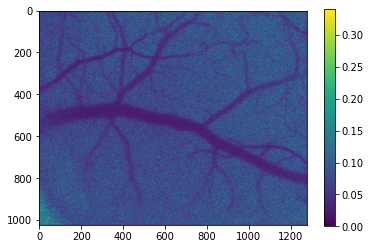

In [3]:
from pylsci import Lsci

# create obbjet
lsci = Lsci()
# calculate spatial contrast on the previously loaded image
s_lsci = lsci.spatial_contrast(raw_speckle_img)
# use helper function to show the contrast image
show_image(s_lsci)

The result is a laser speckle contrast image that shows us the vessels of the rat cortex.

Now, we try a larger spatial neighborhood of a $7 \times 7$ kernel

image dimensions: (1024, 1280)


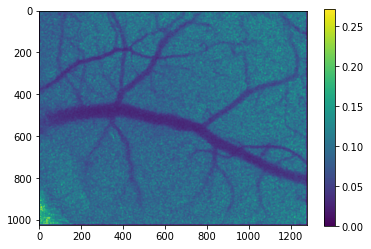

In [8]:
lsci = Lsci(nbh_s=7)
s_lsci = lsci.spatial_contrast(raw_speckle_img)
show_image(s_lsci)


## 2. Temporal Contrast Calculation

To demonstrate the temporal contrast calculation, an example of my thesis project is used. 

The LSCI setup provided a time series of 1000 raw laser speckle image, each of size $64 \times 64$ pixels.
To get all the data in a single image, the 1000 images were stacked vertically, 
providing a single image of size $64000 \times 64$ pixels. 

> Since the project topic was [Fingerprint Presentation Attack Detection using LSCI](https://www.researchgate.net/publication/329391997_Fingerprint_Presentation_Attack_Detection_using_Laser_Speckle_Contrast_Imaging),
> the images captured a time series of 1000 images of an area of size $1 \times 1$ $cm^2$ of the human index finger.

In [9]:
# better avoid showing an image of size 64000 x 64 pixels within this notebook,
# but feel free to download it
raw_speckle_img_seq = read_image('img/temporal.png')
print(f"image dimensions: {raw_speckle_img_seq.shape}")

(64000, 64)

The temporal contrast function of `pylsci` expects a 3D NumPy array, 
where the first dimension represents the time dimension.

In the described LSCI setup, `pylsci` would expect a NumPy array of shape $1000 \times 64 \times 64$.

In order to achieve that, the vertically aligned images need to be stacked, 
and I implemented a helper function for that purpose in the `util.py` module.

> As you see, the preprocessing is highly dependent on the specific LSCI setup.

In [5]:
from util import stack_images

raw_speckle_img_seq = stack_images(raw_speckle_img_seq)
print(f"image dimensions: {raw_speckle_img_seq.shape}")

(1000, 64, 64)

Now the array has the expected dimensions and we can calculate the temporal contrast 
by calling the `temporal_contrast()` function.

Dimensions of the LSCI image in pixels: (64, 64)
image dimensions: (64, 64)


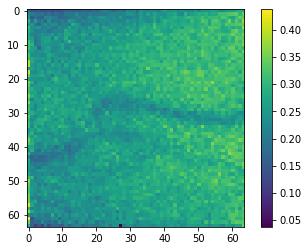

In [6]:
lsci = Lsci()
t_lsci = lsci.temporal_contrast(raw_speckle_img_seq)
show_image(t_lsci)

For the value of the temporal neighborhood, no constratints apply, 
and you can set `nbh_t` to any value that is appropriate.

In [ ]:
lsci = Lsci(nbh_t=80)
t_lsci = lsci.temporal_contrast(raw_speckle_img_seq)
show_image(t_lsci)

## 3. Spatio-Temporal Contrast Calculation

The spatio-temporal contrast can be calculated with the `spatio_temporal_contrast()` function.

It accepts a `cubic` argument (default is `False`), that determines 
if the spatio-temporal neighborhood has a cubic shape (determined by `nbh_s`),
or a cubiod shape (considering `nbh_t`).
For example, if `cubic=True`, the spatio-temporal kernel is a cube of edge size `nbh_s`, and if `nbh_s=7`, 
its size will be $7 \times 7 \times 7$ pixels.
If `cubic` remains `False`, the spatio-temporal kernel will be a cuboid of size $25 \times 7 \times 7$ 
(in case you set `nbh_t=25` and `nbh_s=7`)

Dimensions of the LSCI image in pixels: (64, 64)
image dimensions: (64, 64)


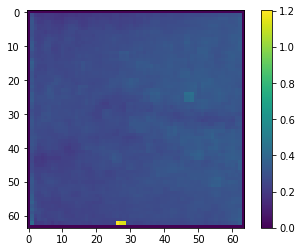

In [7]:
# create the object sing the default values for nbh_s and nbh_t
lsci = Lsci()
# since cubic = True, the spatio-temporal kernel will be of size 3x3x3
st_lsci = lsci.spatio_temporal_contrast(raw_speckle_img_seq, cubic=True)
print(f"Dimensions of the LSCI image in pixels: {st_lsci.shape}")
show_image(st_lsci)

For demo purposes, an example with a cuboid neighborhood of $40 \times 5 \times 5$ wil be shown, however, 
it makes not much sense for the given LSCI images.

In [ ]:
# leaving cubic as false will considers nbh_t for the kernel size, 
# resulting in a spatio-temporal neighborhood of 40x5x5 pixels.
lsci = Lsci(nbh_s=5, nbh_t=40)
st_lsci = lsci.spatio_temporal_contrast(raw_speckle_img_seq)
print(f"Dimensions of the LSCI image in pixels: {st_lsci.shape}")
show_image(st_lsci)


## 4. Conclusion

With `pylsci`, you can calculate laser speckle contrast images in Python.
For production code, you probably want to use MATLAB or a pure C implementation.
However, if you are prototyping or researching,
and want to stick with the Python ecosystem, I hope that `pylsci` suits your needs.
Make sure you use the temporal contrast calculation whenever possible, 
since it doesn't rely on a loop-based implementation like the spatial and spatio-temporal contrast calculation.
If you find a pythonic equivalent of the MATLAB `imfilter()` function (preferrably avoiding dependencies), 
please let me know in the [GitHub Issue](https://github.com/pkeilbach/pylsci/issues/1) or [contact me](mailto:python@pk17.org), 
so I can improve the `pylsci` package.

Last but not least, here is the version information for this notebook:

In [1]:
%load_ext version_information
%version_information


AttributeError: module 'cgi' has no attribute 'escape'

Software versions
Python 3.8.2 64bit [Clang 11.0.0 (clang-1100.0.33.17)]
IPython 7.19.0
OS macOS 10.15.7 x86_64 i386 64bit
Sat Jan 30 18:11:50 2021 CET